# Homework 2: Gaussian Mixture Models

Q1: 20 pts

Q2: 20 pts

Q3: 30 pts

Q4: 30 pts

Q5: 65 pts

Total: 165 pts

In [1]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
warnings.filterwarnings('error')

Here are some helper functions for this assignment, you can read through their purposes when you encounter them, but **no need to change them**. You will not be asked to use them in your coding portion, they will be automatically written for you.

* ``gauss_pm``: stores parameters for Gaussian models, includes pi, mu, sigma, acc (accuracy), and mesg (ignore this). Once created, you can call each parameter by calling ``instance.parameter``, e.g. ``gauss_pm_instance.mu``.

* ``poiss_pm``: stores parameters for Poisson models, includes pi, lda (lambda), acc (accuracy) and mesg (ignore this).

* ``pklload``: function that loads pickle files.

In [2]:
import os
import pickle
from collections import namedtuple

gauss_pm = namedtuple(
    "gauss_pm",
    [
        "pi",
        "mu",
        "sigma",
        "acc",
        "mesg",
    ],
)

poiss_pm = namedtuple(
    "poiss_pm",
    [
        "pi",
        "lda",
        "acc",
        "mesg",
    ],
)

def pklload(*args) -> dict:
    """ Load pkl files.
    
    Args:
        *args: the folder path leading to the pkl file, in order

    Returns:
        data (dict): dictionary containing the data
    """
    f = open(os.path.join(*args), "rb")
    data = pickle.load(f)
    f.close()
    return data

## Question 3: Simulated Data (30 pts)

For Question 3, execute the block below, then scroll down and start from the code block **"Question 3(a-e)"**, and follow instructions from there.

In [3]:
# Load data
data = np.load("./data/ps2a_sim.npy")
num_class, num_trials, num_fea = data.shape

# For saving model parameters, key: (problem set number, model number)
mdl_params = {}
print(data.shape)

(3, 20, 2)


### Question 3(b): Find Model Parameters

Fill in the functions for finding the parameters for models (i)-(iii), then execute the blocks.

In [4]:
# Calculate 1st model parameters

def full_gaussian_shared_cov(data: np.array, num_class: int, num_trials: int, num_fea: int) -> tuple:
    """Calculate the parameters for the Full Gaussian Shared Covariance Model.
    Args:
        data: shape = (num_class, num_trials, num_fea)
        num_class: number of stimulus classes
        num_trials: number of trials
        num_fea: number of features
    Returns:
        pi (np.array): probability of being in a certain class, shape = (num_class)
        mu (np.array): mean of each class, shape = (num_class, num_fea,)
        sigma (np.array): covariance of each class, shape = (num_class, num_fea, num_fea,)

        HINT: sigma is shared between classes, but beware of its designated output shape!
    """
    # ----- YOUR CODE HERE ----- #
    pi = np.zeros((num_class))
    mu = np.zeros((num_class, num_fea))
    sigma = np.zeros((num_class, num_fea, num_fea))

    for i in range(num_class):
        pi[i] = num_trials/(num_trials * num_class)

    for i in range(num_class):
        mu[i] = (np.sum(data[i], axis = 0)) * 1/num_trials
    
    
    sigma = np.zeros((num_class, num_fea, num_fea))
    shared_cov = np.zeros((num_fea, num_fea))

    for class_val in range(num_class):
        temp_cov_mat = np.zeros((num_trials, num_fea))
    
        for trial in range(num_trials):
            temp_cov_mat[trial] = data[class_val][trial] - mu[class_val]

        shared_cov += 1/(num_trials * num_class) * (np.dot(np.transpose(temp_cov_mat), temp_cov_mat))
    
    for class_val in range(num_class):
        sigma[class_val] = shared_cov
    
    return pi, mu, sigma
    # -------------------------- #

pi, mu, sigma = full_gaussian_shared_cov(data, num_class, num_trials, num_fea)
mdl_params[(3, 0)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=None, mesg=None)

In [5]:
# Calculate 2nd model parameters

def full_gaussian_class_cov(data: np.array, num_class: int, num_trials: int, num_fea: int) -> tuple:

    """Calculate the parameters for the Full Gaussian Class Covariance Model.
    Args:
        data: shape = (num_class, num_trials, num_fea)
        num_class: number of stimulus classes
        num_trials: number of trials
        num_fea: number of features

    Returns:
        pi (np.array): probability of being in a certain class, shape = (num_class)
        mu (np.array): mean of each class, shape = (num_class, num_fea,)
        sigma (np.array): covariance of each class, shape = (num_class, num_fea, num_fea,)

    """
    # ----- YOUR CODE HERE ----- #

    pi = np.zeros((num_class))
    mu = np.zeros((num_class, num_fea))
    sigma = np.zeros((num_class, num_fea, num_fea))
    
    for i in range(num_class):
        pi[i] = num_trials/(num_trials * num_class)

    for i in range(num_class):
        mu[i] = (np.sum(data[i], axis = 0)) * 1/num_trials

    sigma = np.zeros((num_class, num_fea, num_fea))
    for class_val in range(num_class):
        temp_cov_mat = np.zeros((num_trials, num_fea))
        for trial in range(num_trials):
            temp_cov_mat[trial] = data[class_val][trial] - mu[class_val]
        sigma[class_val] = 1/num_trials * (np.dot(np.transpose(temp_cov_mat), temp_cov_mat))
             
    return pi, mu, sigma
    # -------------------------- #
pi, mu, sigma = full_gaussian_class_cov(data, num_class, num_trials, num_fea)
mdl_params[(3, 1)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=None, mesg=None)

In [6]:
# Calculate 3rd model parameters

def poiss(data: np.array, num_class: int, num_trials: int, num_fea: int) -> tuple:
    """Calculate the parameters for the Poisson Model.

    Args:
        data: shape = (num_class, num_trials, num_fea)
        num_class: number of stimulus classes
        num_trials: number of trials
        num_fea: number of features
    Returns:
        pi (np.array): probability of being in a certain class, shape = (num_class)
        lda (np.array): the Poisson parameter of each class, shape = (num_class, num_fea,)
    """
    # ----- YOUR CODE HERE ----- #
    pi = np.zeros((num_class))
    lda = np.zeros((num_class, num_fea))
    
    for i in range(num_class):
        pi[i] = num_trials/(num_trials * num_class)

    for i in range(num_class):
        lda[i] = np.sum(data[i], axis = 0) * 1/num_trials
    
    return pi, lda
    # -------------------------- #

pi, lda = poiss(data, num_class, num_trials, num_fea)
mdl_params[(3, 2)] = poiss_pm(pi=pi, lda=lda, acc=None, mesg=None)

### Question 3(d): Gaussian PDF

Fill in the function for calculating the probability density function for a Gaussian variable, then excute the block.

In [7]:
def gaussian_pdf(coor: np.array, mu: np.array, sigma: np.array) -> np.array:
    """Calculate the probability density function of a multivarate Gaussian distribution.

    Args:
        coor: coordinates of the data points, shape = (num_points, num_fea)
        mu: mean of the Gaussian, shape = (num_fea,)
        sigma: covariance of the Gaussian, shape = (num_fea, num_fea)
    Returns:
        pdf (np.array): probability density value for each coordinate, shape = (num_data,)
    """

    # ----- YOUR CODE HERE ----- #
    D = 2
    pdf = np.zeros((len(coor)))
    # count = 0
    # for val_class in range(num_class):
    #     sigma_pdf = sigma[val_class]
    #     mu_pdf = mu[val_class]
    #     data_pdf = data[val_class]
    #     for coor in data_pdf:
    for idx, coord in enumerate(coor):
        temp_exp = np.matmul((coord - mu).transpose(), np.linalg.inv(sigma))
        exponential = np.matmul(temp_exp, (coord-mu))
        pdf_eq = (2*np.pi**(-D/2)) * (np.linalg.det(sigma)**(-1/2)) * np.exp((-1/2 * exponential))
        pdf[idx] = pdf_eq
            # count += 1
    return pdf
    # -------------------------- #


### Question 3(e): Decision Boundary

Fill in the functions for calculating the loglikelihood and decision boundary of both Gaussian and Poisson models, then execute the block.

In [8]:
# Calculate log-likelihood and decision boundary for Gaussian models
def loglikelihood_gaussian(data: np.array, pi: np.array, mu: np.array, sigma: np.array) -> np.array:
    """Calculates the log-likelihood of a multivariate Gaussian distribution.
    Args:
        data: data points, shape = (num_data, num_fea)
        pi: shape = (1,)
        mu: shape = (num_fea,)
        sigma: shape = (num_fea, num_fea)
    Returns:
        ll (np.array): loglikelihood of each data point, shape = (num_data,)
    """
    ll = np.zeros(len(data))
    mu = mu.reshape(-1, 1)
    for idx, point in enumerate(data):
        
        temp_var = np.matmul(mu.transpose(), np.linalg.inv(sigma))
        gauss = np.squeeze(np.matmul(temp_var, point) - (1/2 * np.matmul(temp_var, mu)) + np.log(pi))
        ll[idx] = gauss
    return ll

In [9]:
def gauss_decision_boundary(coor, num_class, pi, mu, sigma):
    stack = []
    for int in range(num_class):
        class_likelihood = loglikelihood_gaussian(coor, pi[int], mu[int], sigma[int])
        stack.append(class_likelihood)
    max_indices = np.argmax(stack, axis = 0)
    return max_indices

In [10]:
def loglikelihood_poisson(arr: np.array, pi: np.array, lda: np.array) -> np.array:
    """Calculates the log-likelihood of a multivariate Poisson distribution.
    Args:
        arr: data points, shape = (num_data, num_fea)
        pi: shape = (num_fea,)
        lda: shape = (num_fea,)
    Returns:
        ll (np.array): loglikelihood of each data point, shape = (num_data,)
    """
    ll = np.zeros(arr.shape[0])
    for i, sample in enumerate(arr):
        dist = 0 
        for j, lda_i in zip(sample, lda):
            dist += j * np.log(lda_i) - lda_i
        ll[i] = np.log(pi) + ( dist)
    return ll

In [11]:
def poiss_decision_boundary(coor, num_class, pi, mu):

    stack = []
    for int in range(num_class):
        class_likelihood = loglikelihood_poisson(coor, pi[int], mu[int])
        stack.append(class_likelihood)

    max_indices = np.argmax(stack, axis=0) 
    return max_indices

### Question 3(a-e)

**Start Question 3 here!**


HINT: when working with each part, if you want to check your progress before moving on, comment out the other parts to avoid errors. Alternatively, put ``continue`` at the end of the part to skip the rest of the code.

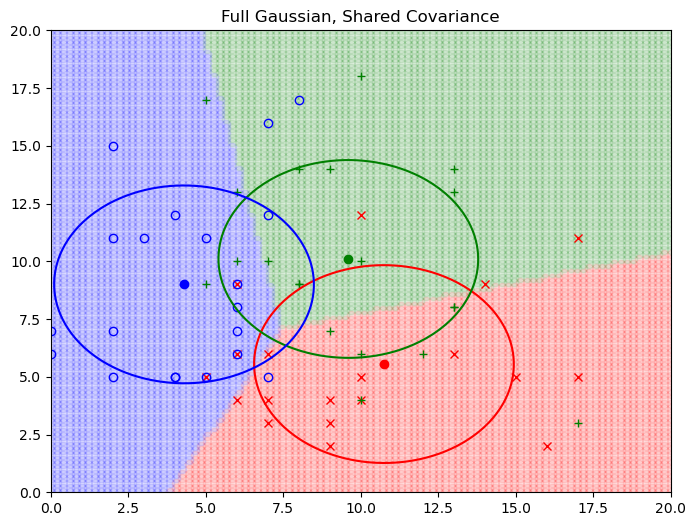

<Figure size 640x480 with 0 Axes>

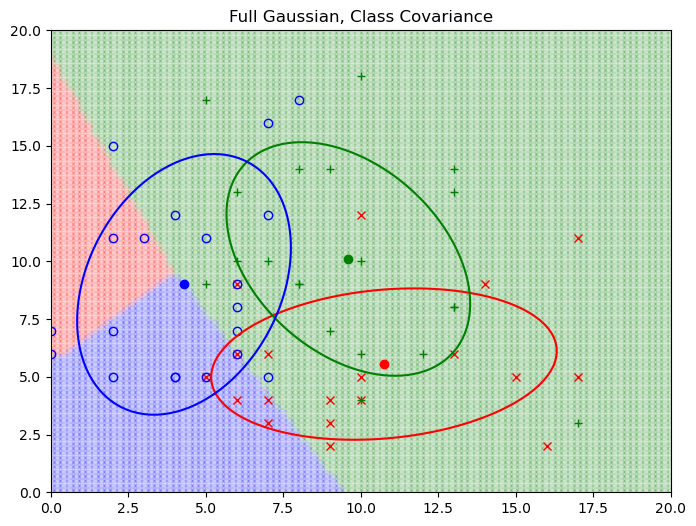

<Figure size 640x480 with 0 Axes>

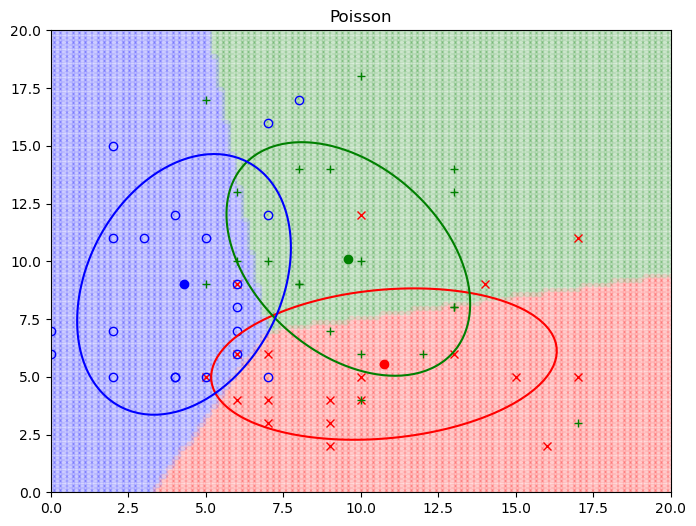

<Figure size 640x480 with 0 Axes>

In [12]:
title = ["Full Gaussian, Shared Covariance", "Full Gaussian, Class Covariance", "Poisson"]

for mdl_idx in range(3):

    # Set up the plot
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    axs.set_xlim((0, 20))
    axs.set_ylim((0, 20))

    # Part a
    for i in range(num_class):
        for j in range(num_trials):
            if i == 2:  
                plt.plot(data[i][j][0], data[i][j][1], 'o', markerfacecolor='none', markeredgecolor='blue')
            else:
                fmt = ["rx", "g+"] 
                plt.plot(data[i][j][0], data[i][j][1], fmt[i])

    # Part b
    # ----- YOUR CODE ELSEWHERE ----- #
    # Go to code block Q3(b) on top and finish the code there.
    # No need to change anything here.
    # ------------------------------- #
    
    mpm = mdl_params[(3, mdl_idx)]
    if isinstance(mpm, gauss_pm):
        mdl_type = "gaussian"
        mu, sigma, pi = mpm.mu, mpm.sigma, mpm.pi 

    elif isinstance(mpm, poiss_pm):
        mdl_type = "poisson"
        mu = lda = mpm.lda
        pi = mpm.pi
        

    # Part c
    plt.plot(mu[0][0], mu[0][1], 'o', color = 'r')
    plt.plot(mu[1][0], mu[1][1], 'o', color = 'g')
    plt.plot(mu[2][0], mu[2][1], 'o', color = 'b')

    # Part d
    Color = ['red', 'green', 'blue']

    for i in range(num_class):
        granularity = 100 
        Z = np.ndarray([granularity, granularity])
        x = np.linspace(0, 20, num = granularity)
        y = np.linspace(0, 20, num = granularity)
        # print(x)
        x, y = np.meshgrid(x,y)
        xy = np.dstack([x, y])
        for j in range(granularity):
            Z[j] = gaussian_pdf(xy[j], mu[i], sigma[i])

        plt.contour(x, y, Z, levels =[0.025], colors = Color[i])

    # Part e
    if (mdl_type == 'gaussian'):
    # if isinstance(mpm, gauss_pm):
    #     mdl_type = "gaussian"      
        gran = 100
        x = np.linspace(0, 20, gran)
        y = np.linspace(0, 20, gran)
        X, Y = np.meshgrid(x, y)
        grid_points = np.column_stack([X.flatten(), Y.flatten()])
        max_indices = gauss_decision_boundary(grid_points, num_class, pi, mu, sigma)

        colors = ['red', 'green', 'blue']
        for trial in range(num_class):
            point_idx = np.where(max_indices == trial)
            for ind_point in point_idx: 
                range_points = grid_points[ind_point]
                for point in range_points:
                    plt.scatter(point[0], point[1], color = colors[trial], alpha = 0.1)

    elif (mdl_type == 'poisson'):
    # elif isinstance(mpm, poiss_pm):
    #     mdl_type = "poisson"
    #     mu = lda = mpm.lda
        gran = 100
        x = np.linspace(0, 20, gran)
        y = np.linspace(0, 20, gran)
        X, Y = np.meshgrid(x, y)
        grid_points = np.column_stack([X.flatten(), Y.flatten()])
        max_indices = poiss_decision_boundary(grid_points, num_class, pi, mu)

        colors = ['red', 'green', 'blue']
        for trial in range(num_class):
            point_idx = np.where(max_indices == trial)
            for ind_point in point_idx: 
                range_points = grid_points[ind_point]
                for point in range_points:
                    plt.scatter(point[0], point[1], color = colors[trial], alpha = 0.1)

    axs.set_title(title[mdl_idx])
    plt.show(mdl_idx + 1)
    plt.clf()

## Question 4: Real Neural Data (30 pts)

### Question 4(a): Find Model Parameters

In [13]:
# Load data
train = np.load("data/ps2a_train.npy")
test = np.load("data/ps2a_test.npy")
train_class, train_trials, train_fea = train.shape
test_class, test_trials, test_fea = test.shape
print(train_class, train_trials, train_fea)

8 91 97


In [14]:
# Calculate model parameters
def full_train_gauss_shared_cov(train_class, train_trials, train_fea) -> tuple:

    pi_train = np.zeros((train_class))
    mu_train = np.zeros((train_class, train_fea))
    sigma_train = np.zeros((train_class, train_fea, train_fea))

    for i in range(train_class):
        pi_train[i] = train_trials/(train_trials*train_class)

    for i in range(train_class):
        mu_train[i] = np.sum(train[i], axis = 0) * 1/train_trials

    train_shared_cov = np.zeros((train_fea, train_fea))

    for class_val in range(train_class):
        temp_mat = np.zeros((train_trials, train_fea))
        for trial in range(train_trials):
            temp_mat[trial] = train[class_val][trial] - mu_train[class_val]
        
        train_shared_cov += 1/(train_trials * train_class) * (np.dot(np.transpose(temp_mat), temp_mat))
        
    for class_val in range(train_class):
        sigma_train[class_val] = train_shared_cov
        
    return pi_train, mu_train, sigma_train
# -------------------------- #

pi_train, mu_train, sigma_train = full_train_gauss_shared_cov(train_class, train_trials, train_fea)

# print(sigma_train)

In [15]:
# Decision boundary + accuracy
correct_pred = 0
total_points = 0

for k in range(num_class):
    assignments = gauss_decision_boundary(test[k], train_class, pi_train, mu_train, sigma_train)

    correct_assignments = (assignments == k)
    correct_pred += correct_assignments.sum()
    total_points += len(test[k])
acc = correct_pred/total_points

print(f"Model(i) accuracy: {acc:.4f}")

# # Save model parameters
mdl_params[(4, 0)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=acc, mesg=None)

Model(i) accuracy: 0.9451


### Question 4(b): Python Warning

In [16]:
# Calculate model parameters
pi_train, mu_train, sigma_train = full_gaussian_class_cov(train, train_class, train_trials, train_fea)

# print(sigma_train)

In [17]:
# Decision boundary
for k in range(num_class):
    try: 
        # ----- YOUR CODE HERE ----- #
        gauss_decision_boundary(test[k], train_class, pi_train, mu_train, sigma_train)
        pass
        # -------------------------- #
    except Exception as e:
        print("The following error was raised: " + str(e))

The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix


In [18]:
# What was the cause of the error message?

# ----- YOUR CODE HERE ----- #
# Put your answer in the string ``ans``.
# HINT: To see a more complete error message, you can remove the exception handling (try-except) in the previous code block.
ans = 'The singular matrix error is raised when the covariance matrix (sigma) \n                                   does not have all of the columns linearly independent.'
# -------------------------- #

print(f"The cause of the error message is: {ans}")

# Save model parameters
mdl_params[(4, 1)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=None, mesg=ans)

The cause of the error message is: The singular matrix error is raised when the covariance matrix (sigma) 
                                   does not have all of the columns linearly independent.


### Question 4(c): Python Warning

In [19]:
# Calculate model parameters

# ----- YOUR CODE HERE ----- #
train_poiss_pi, train_poiss_lda = poiss(train, train_class, train_trials, train_fea)
# -------------------------- #

In [20]:
loglikelihood_poisson(train[0], train_poiss_pi[0], train_poiss_lda[0])

RuntimeWarning: divide by zero encountered in log

In [21]:
# Decision boundary

for k in range(num_class):
    try:
        # ----- YOUR CODE HERE ----- #
        poiss_decision_boundary(train[k], train_class, train_poiss_pi[k], train_poiss_lda[k])
        # HINT: you can re-use the code from Q3.
        pass
        # -------------------------- #
    except Exception as e:
        print("The following error was raised: " + str(e))

The following error was raised: invalid index to scalar variable.
The following error was raised: invalid index to scalar variable.
The following error was raised: invalid index to scalar variable.


In [22]:
# What was the cause of the error message?

# ----- YOUR CODE HERE ----- #
# Put your answer in the string ``ans``.
# HINT: To see a more complete error message, you can remove the exception handling (try-except) in the previous code block.
ans = "A 'divide by zero encountered in log' was the reason for this error. Lambda should not be 0 for a Poisson distribution"
# -------------------------- #

print(f"The cause of the error message is: {ans}")

# Save model parameters
mdl_params[(4, 2)] = poiss_pm(pi=pi, lda=lda, acc=None, mesg=ans)

The cause of the error message is: A 'divide by zero encountered in log' was the reason for this error. Lambda should not be 0 for a Poisson distribution


### Question 4(d): Minimum Variance Poisson Model

In [23]:
# Modify model parameters

# ----- YOUR CODE HERE ----- #
def poiss_mod(data: np.array, num_class: int, num_trials: int, num_fea: int):
    """Calculate the parameters for the modified Poisson model.
    
    Args:
        data: shape = (num_class, num_trials, num_fea)
        num_class: number of stimulus classes
        num_trials: number of trials
        num_fea: number tof features
    Returns:
        pi (np.array): probability of being in a certain class, shape = (num_class)
        lda_mod (np.array): the Poisson parameter of each class, shape = (num_class, num_fea,)
        
    """
    pi = np.zeros((num_class))
    lda_mod = np.zeros((num_class, num_fea))
    threshold = 0.01
    for i in range(num_class):
        pi[i] = num_trials/(num_trials * num_class)

    for i in range(num_class):
        lda_mod[i] = np.sum(data[i], axis = 0) * 1/train_trials

    lda_mod[lda_mod < threshold] = 0.01
    return pi, lda_mod
   
pi, lda_mod = poiss_mod(train, train_class, train_trials, train_fea)

In [24]:
# Decision boundary + accuracy
correct_pred = 0
total_points = 0

for k in range(num_class):
    assignments = poiss_decision_boundary(test[k], train_class, pi, lda_mod)
    correct_assignments = (assignments == k)
    correct_pred += correct_assignments.sum()
    total_points += len(test[k])
acc = correct_pred/total_points

print(f"Model(iii) accuracy: {acc:.4f}")

# # Save model parameters
mdl_params[(4, 3)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=acc, mesg=None)

Model(iii) accuracy: 0.9414


## Question 5: EM Algroithm (65 pts)

In [59]:
# Load data

data = pklload("data/ps2b_data.pkl")
pm1 = data["InitParams1"]
pm2 = data["InitParams2"]
spikes = data["spikes"]

K = pm1["mu"].shape[1] # number of contributing neurons
D, N = spikes.shape # number of trials, spike count

### Question 5(a)

Write the EM algorithm for the Gaussian Mixture Model, and plot the log likelihood as a function of iteration steps.

In [60]:
def EM_GMM(pm: dict):
    """ EM algorithm for Gaussian mixture model.
    Args:
        pm: parameters, has (key, value) pairs:
            "mu": array of shape (31, 3)
            "sigma": array of shape (31, 31, 3)
            "pi": array of shape (1, 3)
    
    Returns:
        mu (np.array): shape of (31, 3)
        sigma (np.array): shape of (31, 31, 3)
        pi (np.array): shape of (3,)
        gam (np.array): shape of (3, 552)
        LL (array-like): contains log-likelihood at each iteration step
    """
    # ----- YOUR CODE HERE ----- #
    raise NotImplementedError
    # -------------------------- #

In [61]:
mu, sigma, ppi, gam, LL = EM_GMM(pm1)

fig, axs = plt.subplots(2, 1, figsize=(4, 4))
axs[0].plot(LL, "b")
axs[1].plot(LL[:10], "b")
axs[1].set_xlabel("steps")
axs[0].set_ylabel("log likelihood")
axs[1].set_ylabel("log likelihood")
plt.tight_layout()
plt.show()

NotImplementedError: 

What are the $\pi$ values?

In [62]:
print(f"The pi values are: {ppi}")

NameError: name 'ppi' is not defined

For each cluster (k = 1, 2, 3), create a separate “voltage versus time” plot.

In [ ]:
f_0 = 30000
t_spike = np.arange(D) / f_0
maxGAMMA = np.argmax(gam, axis=0)

plt.figure(figsize=(8, 6))
for k in range(K):
    plt.subplot(K, 1, k + 1)

    # ----- YOUR CODE HERE ----- #
    pass
    # -------------------------- #
    
    plt.xlabel('time (seconds)')
    plt.ylabel('potential (mV)')
    plt.tight_layout()
    plt.title('Cluster {} voltage versus time'.format(k + 1))
plt.show()

### Question 5(b)

Run the EM algorithm on the same data as in Problem 2, but now initializing the model parameters using InitParams2. This should lead to an error. Why did the error occur?

In [ ]:
try:
    # ----- YOUR CODE HERE ----- #
    pass
    # -------------------------- #
except Exception as e:
    print("The following error was raised: " + str(e))

# ----- YOUR CODE HERE ----- #
# Put your answer in the string ``ans``.
# HINT: To see a more complete error message, you can remove the exception handling (try-except) in the previous code block.
ans = NotImplemented
# -------------------------- #

print(f"The cause of the error message is: {ans}")